In [1]:
import json
from pathlib import PosixPath
import ntpath
from fastai.vision import *

from adapter import loss_func, get_y_func, load_voc, has_person, json_to_paths, create_split_func, YoloCategoryList, \
    ApAt50
from models import Darknet
from train import hyp
from utils import torch_utils

In [2]:
base_path = PosixPath('/home/bgardner/datasets/alleyway/')
img_path = base_path / 'original'
json_path = base_path / "export_export.json"
with open(json_path) as f:
    content = f.readlines()
content = [x.strip() for x in content] 
len(content)

481

In [3]:
print(f"line={content[0]}")

line={"name":"projects/mersive-kepler/datasets/5dedebd9_0000_228f_a4d6_089e08323328/annotatedDatasets/3400948208154275476-3400948208154273846/examples/2121299680134532113","image_payload":{"mime_type":"IMAGE_PNG","image_uri":"gs://rnd-alleyway/2019-10-15T15-06-32.985523.png"},"annotations":[{"name":"projects/mersive-kepler/datasets/5dedebd9_0000_228f_a4d6_089e08323328/annotatedDatasets/3400948208154275476-3400948208154273846/examples/2121299680134532113/annotations/10294068833117950158","annotation_source":3,"annotation_value":{"image_bounding_poly_annotation":{"annotation_spec":{"display_name":"person"},"normalized_bounding_poly":{"normalized_vertices":[{"x":0.50287437,"y":0.50252271},{"x":0.58000398,"y":0.62749213}]}}},"annotation_metadata":{"operator_metadata":{}}},{"name":"projects/mersive-kepler/datasets/5dedebd9_0000_228f_a4d6_089e08323328/annotatedDatasets/3400948208154275476-3400948208154273846/examples/2121299680134532113/annotations/11466785836066768684","annotation_source":3

In [4]:
jso = json.loads(content[0])
print(json.dumps(jso, indent=2))

{
  "name": "projects/mersive-kepler/datasets/5dedebd9_0000_228f_a4d6_089e08323328/annotatedDatasets/3400948208154275476-3400948208154273846/examples/2121299680134532113",
  "image_payload": {
    "mime_type": "IMAGE_PNG",
    "image_uri": "gs://rnd-alleyway/2019-10-15T15-06-32.985523.png"
  },
  "annotations": [
    {
      "name": "projects/mersive-kepler/datasets/5dedebd9_0000_228f_a4d6_089e08323328/annotatedDatasets/3400948208154275476-3400948208154273846/examples/2121299680134532113/annotations/10294068833117950158",
      "annotation_source": 3,
      "annotation_value": {
        "image_bounding_poly_annotation": {
          "annotation_spec": {
            "display_name": "person"
          },
          "normalized_bounding_poly": {
            "normalized_vertices": [
              {
                "x": 0.50287437,
                "y": 0.50252271
              },
              {
                "x": 0.58000398,
                "y": 0.62749213
              }
            ]
   

In [5]:
samples = [json.loads(s) for s in content]


In [6]:
def jso2path(o):
    return img_path / ntpath.basename(o['image_payload']['image_uri'])

images = {jso2path(o): o for o in samples}
posix_paths = [jso2path(o) for o in samples]

In [7]:
# Load the model
img_size = (352, 608)
device = 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
weights = 'weights/best.pt'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, img_size=img_size, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
model.load_state_dict(torch.load(weights, map_location=device)['model'])

# Build the paths and pass them to the FastAI ObjectItemList
lst = ObjectItemList(posix_paths, label_cls=YoloCategoryList)
YoloCategoryList.anchors = [model.module_list[l].anchors for l in model.yolo_layers]
YoloCategoryList.img_size = img_size

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070 with Max-Q Design', total_memory=7982MB)



In [14]:
def label_func(path):
    sz = (640, 360)
    image = images[path]
    boxes = []
    for anno in image['annotations']:
        val = anno['annotation_value']
        poly = val['image_bounding_poly_annotation']
        normed = poly['normalized_bounding_poly']
        verts = normed['normalized_vertices']
        box = np.array([
            int(verts[0]['y'] * sz[1]), 
            int(verts[0]['x'] * sz[0]), 
            int(verts[1]['y'] * sz[1]), 
            int(verts[1]['x'] * sz[0])
        ])
        boxes.append(box)
    classes = ['person'] * len(boxes)
    return [boxes, classes]

# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_rand_pct()                   
        .label_from_func(label_func)
        .transform(
    get_transforms(),
    tfm_y=True,
    size=img_size,
    resize_method=ResizeMethod.PAD,
    padding_mode='zeros'
)
        .databunch(bs=16, collate_fn=bb_pad_collate))



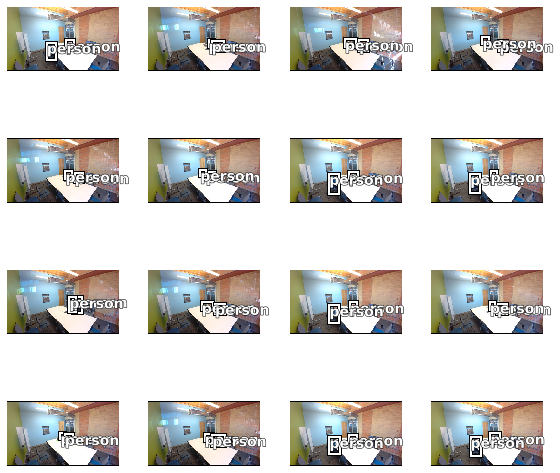

In [15]:
# Show the images so we can visually validate
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(8, 8))
